In [1]:
from getpass import getpass               # for login password prompts

import time
import numpy as np                        # for manipulating arrays
import pandas as pd
import json                               # to pretty-print dicts

from astropy import units as u            # astropy utilities
from astropy.coordinates import SkyCoord
from astropy.table import Table

from matplotlib import pyplot as plt      # visualization libs
from IPython.display import display
from dl.helpers.utils import convert
%matplotlib inline

# Data Lab imports
from dl import storeClient as sc          # needed to use virtual storage
from dl import queryClient as qc          # needed to query Data Lab catalogs
from dl import authClient as ac           # needed for login authentication

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [2]:
token = ac.login(input("Enter user name: "), getpass("Enter password: "))

Enter user name:  jlmaurora
Enter password:  ···········


In [3]:
# pip install --ignore-installed --no-cache-dir noaodatalab

In [4]:
#sc.put('BD_LS_SDSS_WISE.csv','vos://training_data')
#sc.put('highzQSO_LS_SDSS_WISE.csv','vos://training_data')

In [5]:
# paste the training process here, if not flux, use magnitude

# Get Training Data

In [3]:
# remove inf

content_BD_LS_SDSS_WISE = []

with open('BD_LS_SDSS_WISE.csv', 'r') as fr:
    for line in fr:
        if 'inf' in line.lower():
            print(line)
        else:
            content_BD_LS_SDSS_WISE.append(line)

with open('BD_LS_SDSS_WISE.processed.csv', 'w') as fw:
    for line in content_BD_LS_SDSS_WISE:
        fw.write(line)
        
content_highzQSO_LS_SDSS_WISE = []

with open('highzQSO_LS_SDSS_WISE.csv', 'r') as fr:
    for line in fr:
        if 'inf' in line.lower():
            print(line)
        else:
            content_highzQSO_LS_SDSS_WISE.append(line)

with open('highzQSO_LS_SDSS_WISE.processed.csv', 'w') as fw:
    for line in content_highzQSO_LS_SDSS_WISE:
        fw.write(line)

1.5854,-17.3475,inf,inf,18.213,184.33599999999998,16.1442,16.4723,0.0,0.0,51.856,348.597,257.67900000000003,0.5966666280866719,,,,,,,,,,,,,,,,

2.2073,-17.6564,inf,inf,20.5169,24.4666,19.2606,18.2263,0.0,0.0,6.21234,19.7585,51.223,2.41423328734635,,,,,,,,,,,,,,,,

3.4953,-18.2797,inf,inf,19.3178,100.979,17.2554,17.4796,0.0,0.0,18.7449,125.271,101.9,2.68909302054212,,,,,,,,,,,,,,,,

7.231,-19.4546,inf,inf,16.4873,838.5930000000001,15.1985,15.581,0.0,0.0,254.15200000000002,832.95,585.599,1.8297062716930699,,,,,,,,,,,,,,,,

21.191999999999997,-57.7604,26.2514,inf,18.7086,150.981,16.4744,16.7199,0.031581,0.0,32.8519,257.17900000000003,205.13299999999998,0.10161605395849099,,,,,,,,,,,,,,,,

25.4926,-46.5659,inf,inf,17.459,576.332,15.2635,15.5084,0.0,0.0,103.845,784.533,626.092,2.0752016148202,,,,,,,,,,,,,,,,

26.5048,-45.7573,inf,inf,16.6083,711.357,15.4394,15.8325,0.0,0.0,227.345,667.192,464.50300000000004,2.86808595464195,,,,,,,,,,,,,,,,

48.4352,4.5546,inf,inf,15.4486,1164.91,15.054,15.4

## replace values

In [4]:
# the training data for flux
cols=['ls_flux_g', 'ls_flux_r', 'ls_flux_z', 'flux_w1', 'flux_w2'] # high_z and brown dwarf files' column names 
high_z = pd.read_csv('highzQSO_LS_SDSS_WISE.processed.csv', index_col=False, usecols=cols, dtype='float64')
BD = pd.read_csv('BD_LS_SDSS_WISE.processed.csv', index_col=False, usecols=cols, dtype='float64')

In [5]:
print('high-z data description')
high_z.describe()

high-z data description


,ls_flux_g,ls_flux_r,ls_flux_z,flux_w1,flux_w2
count,405.000000,405.000000,405.000000,405.000000,405.000000
mean,0.013066,1.031373,9.242325,15.961031,17.962643
std,0.081456,1.637223,9.435377,17.436935,20.401103
min,-0.105683,-0.133399,0.228144,-2.435520,-9.572200
25%,-0.026294,0.031895,2.593560,5.438830,5.727600
50%,-0.003686,0.270796,6.648010,11.965900,12.911400
75%,0.032757,1.512780,12.925300,21.806600,24.446000
max,0.976930,12.915400,65.917500,142.597000,169.357000


In [6]:
print('BD data description')
BD.describe()

BD data description


,ls_flux_g,ls_flux_r,ls_flux_z,flux_w1,flux_w2
count,1579.000000,1.579000e+03,1579.000000,1579.000000,1579.000000
mean,1299.707250,-2.253111e+05,401.005719,2842.579878,2239.992070
std,24751.348495,9.052413e+06,3405.740783,33466.889153,25811.745018
min,-14015.800000,-3.597050e+08,-7377.860000,-578.113000,-1901.980000
25%,0.003995,1.940780e-01,5.902800,25.429400,30.553900
50%,0.073383,7.391000e-01,30.223600,110.356000,83.378400
75%,0.231415,2.022705e+00,72.325850,304.115500,226.580500
max,491775.000000,9.421120e+05,54810.000000,903581.000000,638079.000000


### try replacing with mean

In [7]:
high_z_replace = {}
BD_replace = {}
for col in cols:
    high_z[col] = high_z[col].replace([np.nan, np.inf, -np.inf], high_z[col].mean())
    BD[col] = BD[col].replace([np.nan, np.inf, -np.inf], BD[col].mean())
    high_z_replace[col] = high_z[col].mean()
    BD_replace[col] = BD[col].mean()

The replacement values are:

In [8]:
print('high_z_replace: ', high_z_replace)
print('BD_replace: ', BD_replace)

high_z_replace:  {'ls_flux_g': 0.01306635061728395, 'ls_flux_r': 1.031372686419753, 'ls_flux_z': 9.242325328395061, 'flux_w1': 15.96103134074074, 'flux_w2': 17.962642698765432}
BD_replace:  {'ls_flux_g': 1299.7072500519319, 'ls_flux_r': -225311.10073351557, 'ls_flux_z': 401.005719207093, 'flux_w1': 2842.5798775009503, 'flux_w2': 2239.9920703837874}


The brown dwarf's flux???

In [9]:
# get the training data flux
# get color labels
g = cols[0]
r = cols[1]
z = cols[2]
w1 = cols[3]
w2 = cols[4]
    
# get fluxes
qso_flux_g = high_z[g]
qso_flux_r = high_z[r]
qso_flux_z = high_z[z]
qso_flux_w1 = high_z[w1]
qso_flux_w2 = high_z[w2]
        
bd_flux_g = BD[g]
bd_flux_r = BD[r]
bd_flux_z = BD[z]
bd_flux_w1 = BD[w1]
bd_flux_w2 = BD[w2]
    
# construct dataframes
# if label=1, it's a qso; if label=0, it's a bd
data_qso = pd.DataFrame({'g': qso_flux_g, 'r': qso_flux_r, 'z': qso_flux_z, 'w1': qso_flux_w1, 'w2': qso_flux_w2, 'label': np.ones(len(qso_flux_g))})
# data_qso.replace([np.inf, 0, -999.0, -np.inf], np.nan,inplace=True) # get rid of Inf
data_bd = pd.DataFrame({'g': bd_flux_g, 'r': bd_flux_r, 'z': bd_flux_z, 'w1': bd_flux_w1, 'w2': bd_flux_w2, 'label': np.zeros(len(bd_flux_g))})
# data_bd.replace([np.inf, 0, -999.0, -np.inf], np.nan,inplace=True)# get rid of Inf

In [10]:
'''if key == "ratio":
        h_ratio_gz, h_ratio_gw1, h_ratio_gw2 = qso_flux_g/qso_flux_z, qso_flux_g/qso_flux_w1, qso_flux_g/qso_flux_w2
        h_ratio_rz, h_ratio_rw1, h_ratio_rw2 = qso_flux_r/qso_flux_z, qso_flux_r/qso_flux_w1, qso_flux_r/qso_flux_w2
        
        bd_ratio_gz, bd_ratio_gw1, bd_ratio_gw2 = bd_flux_g/bd_flux_z, bd_flux_g/bd_flux_w1, bd_flux_g/bd_flux_w2
        bd_ratio_rz, bd_ratio_rw1, bd_ratio_rw2 = bd_flux_r/bd_flux_z, bd_flux_r/bd_flux_w1, bd_flux_r/bd_flux_w2
        
        data_qso = pd.DataFrame({'g/z': h_ratio_gz, 'g/w1': h_ratio_gw1, 'g/w2': h_ratio_gw2, 'r/z': h_ratio_rz, 'r/w1': h_ratio_rw1, 'r/w2': h_ratio_rw2, 'label': np.ones(len(h_ratio_gz))})
        # data_qso.replace([np.inf, 0, -999.0, -np.inf], np.nan, inplace=True) # get rid of Inf
        data_bd = pd.DataFrame({'g/z': bd_ratio_gz, 'g/w1': bd_ratio_gw1, 'g/w2': bd_ratio_gw2, 'r/z': bd_ratio_rz, 'r/w1': bd_ratio_rw1, 'r/w2': bd_ratio_rw2, 'label': np.zeros(len(bd_ratio_gz))})
        # data_bd.replace([np.inf, 0, -999.0, -np.inf], np.nan,inplace=True) # get rid of Inf
    
    # return flux dataframes which include qsos and brown dwarfs
    return data_qso, data_bd '''

'if key == "ratio":\n        h_ratio_gz, h_ratio_gw1, h_ratio_gw2 = qso_flux_g/qso_flux_z, qso_flux_g/qso_flux_w1, qso_flux_g/qso_flux_w2\n        h_ratio_rz, h_ratio_rw1, h_ratio_rw2 = qso_flux_r/qso_flux_z, qso_flux_r/qso_flux_w1, qso_flux_r/qso_flux_w2\n        \n        bd_ratio_gz, bd_ratio_gw1, bd_ratio_gw2 = bd_flux_g/bd_flux_z, bd_flux_g/bd_flux_w1, bd_flux_g/bd_flux_w2\n        bd_ratio_rz, bd_ratio_rw1, bd_ratio_rw2 = bd_flux_r/bd_flux_z, bd_flux_r/bd_flux_w1, bd_flux_r/bd_flux_w2\n        \n        data_qso = pd.DataFrame({\'g/z\': h_ratio_gz, \'g/w1\': h_ratio_gw1, \'g/w2\': h_ratio_gw2, \'r/z\': h_ratio_rz, \'r/w1\': h_ratio_rw1, \'r/w2\': h_ratio_rw2, \'label\': np.ones(len(h_ratio_gz))})\n        # data_qso.replace([np.inf, 0, -999.0, -np.inf], np.nan, inplace=True) # get rid of Inf\n        data_bd = pd.DataFrame({\'g/z\': bd_ratio_gz, \'g/w1\': bd_ratio_gw1, \'g/w2\': bd_ratio_gw2, \'r/z\': bd_ratio_rz, \'r/w1\': bd_ratio_rw1, \'r/w2\': bd_ratio_rw2, \'label\': np.zero

In [10]:
# put the data containing info about qso and bd together
data_train = pd.concat([data_qso, data_bd], ignore_index=True).dropna() # make sure that the data is lined up
X = data_train[['g', 'r', 'z', 'w1', 'w2']]
y = data_train['label']

In [12]:
'''if key == 'ratio':
    data_qso, data_bd = get_data_flux('ratio', high_z, BD)
    data_train = pd.concat([data_qso, data_bd], ignore_index=True).dropna()
    X = data_train[['g/z', 'g/w1', 'g/w2', 'r/z', 'r/w1', 'r/w2']]'''

"if key == 'ratio':\n    data_qso, data_bd = get_data_flux('ratio', high_z, BD)\n    data_train = pd.concat([data_qso, data_bd], ignore_index=True).dropna()\n    X = data_train[['g/z', 'g/w1', 'g/w2', 'r/z', 'r/w1', 'r/w2']]"

In [11]:
print(data_train.head())
print(X.head())
print(X.tail(5))
print(y.head())
print(y.tail(5))

          g         r          z         w1         w2  label
0 -0.027202  1.128900  15.478700  25.508100  31.962400    1.0
1 -0.009716 -0.004347   0.447343   0.193634  -0.005911    1.0
2 -0.009741 -0.002475   0.471304   1.737770   0.771748    1.0
3  0.016594  1.172370  19.526800  26.206800  32.328100    1.0
4  0.010978 -0.009939   0.837811   3.343330   1.152640    1.0
          g         r          z         w1         w2
0 -0.027202  1.128900  15.478700  25.508100  31.962400
1 -0.009716 -0.004347   0.447343   0.193634  -0.005911
2 -0.009741 -0.002475   0.471304   1.737770   0.771748
3  0.016594  1.172370  19.526800  26.206800  32.328100
4  0.010978 -0.009939   0.837811   3.343330   1.152640
                g              r           z           w1          w2
3423     0.001760       0.283210   10.638200    57.675300    43.33980
3424     0.217841       0.231266    0.216917   385.948000   376.21600
3425    -0.001194       0.155733   13.277800    69.401300    68.65910
3426  1299.707250 

# Get color-color plots

In [12]:
# color plots

def flux_color(qso1, qso2, qso3, qso4, x_lab, y_lab):
    # x: qso1-qso2
    # y: qso3-qso4
    plt.scatter(qso1 - qso2, qso3 - qso4, marker='*', alpha=0.4, label='qso')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.xlim([min(qso1 - qso2), max(qso1 - qso2)])
    plt.ylim([min(qso3 - qso4), max(qso3 - qso4)])
    plt.legend()

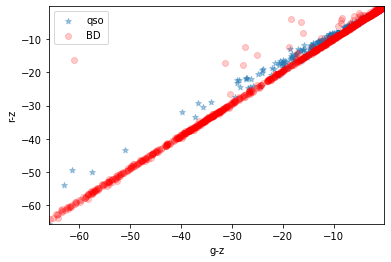

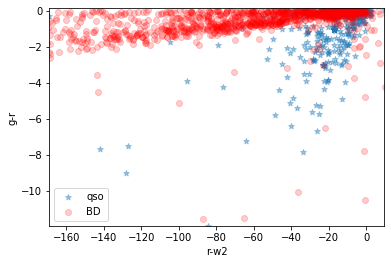

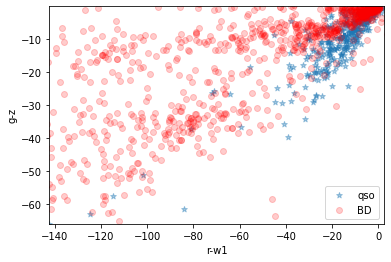

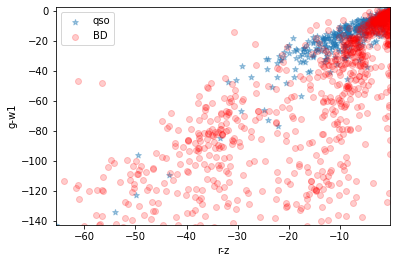

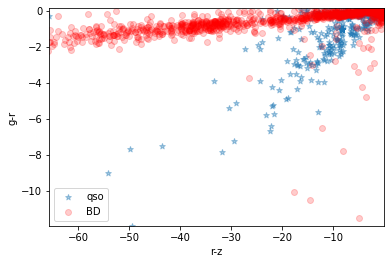

In [20]:
# r-z VS g-z

plt.scatter(qso_flux_g - qso_flux_z, qso_flux_r - qso_flux_z, marker='*', alpha=0.4, label='qso')
plt.xlabel('g-z')
plt.ylabel('r-z')
plt.legend()

plt.scatter(bd_flux_g - bd_flux_z, bd_flux_r - bd_flux_z, marker='o', alpha=0.2, label='BD', color='r')
plt.xlabel('g-z')
plt.ylabel('r-z')
plt.xlim([min(qso_flux_g - qso_flux_z), max(qso_flux_g - qso_flux_z)])
plt.ylim([min(qso_flux_r - qso_flux_z), max(qso_flux_r - qso_flux_z)])
plt.legend()
plt.show()

# g-r VS r-w2
flux_color(qso_flux_r, qso_flux_w2, qso_flux_g, qso_flux_r, 'r-w2', 'g-r')
plt.scatter(bd_flux_r - bd_flux_w2, bd_flux_g - bd_flux_r, marker='o', alpha=0.2, label='BD', color='r')
plt.legend()
plt.show()

# g-z VS r-w1
flux_color(qso_flux_r, qso_flux_w1, qso_flux_g, qso_flux_z, 'r-w1', 'g-z')
plt.scatter(bd_flux_r - bd_flux_w1, bd_flux_g - bd_flux_z, marker='o', alpha=0.2, label='BD', color='r')
plt.legend()
plt.show()

# r-z VS g-w1
flux_color(qso_flux_r, qso_flux_z, qso_flux_g, qso_flux_w1, 'r-z', 'g-w1')
plt.scatter(bd_flux_r - bd_flux_z, bd_flux_g - bd_flux_w1, marker='o', alpha=0.2, label='BD', color='r')
plt.legend()
plt.show()

# g-r VS r-z
flux_color(qso_flux_r, qso_flux_z, qso_flux_g, qso_flux_r, 'r-z', 'g-r')
plt.scatter(bd_flux_r - bd_flux_z, bd_flux_g - bd_flux_r, marker='o', alpha=0.2, label='BD', color='r')
plt.legend()
plt.show()

## KNN to get (multidimensional) flux filters

https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot

In [14]:
features = [X['r']-X['w2'], X['g']-X['r'], X['r']-X['w1'], X['g']-X['z'], X['r']-X['z'], X['g']-X['w1']]
Xf = np.array(features).transpose()
print(Xf[:5, :], '\n length:\n', len(Xf))
yf = y
print(yf[:5])

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.3,random_state=42)
'''
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.01, 0.1, 1, 10]}
svc = svm.SVC(random_state=42)
print('start fitting')
clff = GridSearchCV(svc, parameters)
clff.fit(Xf_train, yf_train)
print('finish fitting')
'''
print('start fitting')
clff = svm.SVC(kernel='poly', C=10, max_iter=2000)
clff.fit(Xf_train, yf_train)
yf_pred = clff.predict(Xf_test)
print(yf_test)
print("filter accuracy:", accuracy_score(yf_test, yf_pred))
print('filter f1 score:', f1_score(yf_test, yf_pred))

[[-3.0833500e+01 -1.1561020e+00 -2.4379200e+01 -1.5505902e+01
  -1.4349800e+01 -2.5535302e+01]
 [ 1.5640000e-03 -5.3690000e-03 -1.9798100e-01 -4.5705900e-01
  -4.5169000e-01 -2.0335000e-01]
 [-7.7422300e-01 -7.2660000e-03 -1.7402450e+00 -4.8104500e-01
  -4.7377900e-01 -1.7475110e+00]
 [-3.1155730e+01 -1.1557760e+00 -2.5034430e+01 -1.9510206e+01
  -1.8354430e+01 -2.6190206e+01]
 [-1.1625790e+00  2.0917000e-02 -3.3532690e+00 -8.2683300e-01
  -8.4775000e-01 -3.3323520e+00]] 
 length:
 3428
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: label, dtype: float64
start fitting
578     0.0
1055    0.0
564     0.0
2297    0.0
2692    0.0
       ... 
2066    0.0
3240    0.0
1340    0.0
2077    0.0
1424    0.0
Name: label, Length: 1029, dtype: float64
filter accuracy: 0.8279883381924198
filter f1 score: 0.0


kernel='linear': 

C=0.01 -> accuracy score=0.827988

C=0.1 -> accuracy score=0.827016

C=1 -> accuracy score=0.827016

C=10 -> accuracy score=0.827016

kernel='poly':

C=0.01 -> accuracy score=0.827988

C=0.1 -> accuracy score=0.827988

C=1 -> accuracy score=0.827988

C=10 -> accuracy score=0.827988

kernel='rbf':
C=0.01 -> accuracy score=0.827988

C=0.1 -> accuracy score=0.827988

C=1 -> accuracy score=0.827988

C=10 -> accuracy score=0.827988

In [102]:
'''
clf1 = svm.SVC(C=100, kernel='poly', gamma=10, degree=5)
clf1.fit(X1,y1)

print('finish fitting; start plotting')

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# Set-up grid for plotting.
x1_min, x1_max = min(qso_flux_r - qso_flux_w2) - 1, max(qso_flux_r - qso_flux_w2) + 1
y1_min, y1_max = min(qso_flux_g - qso_flux_r) - 1, max(qso_flux_g - qso_flux_r) + 1
h = (x1_max - x1_min)/100
xx1, yy1 = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(y1_min, y1_max, h))

plot_contours(ax, clf1, xx1, yy1, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(bd_flux_r - bd_flux_w2, bd_flux_g - bd_flux_r, marker='o', alpha=0.2, label='BD', color='r')
ax.scatter(qso_flux_r - qso_flux_w2, qso_flux_g - qso_flux_r, marker='*', alpha=0.4, label='qso')
ax.set_ylabel('g-r')
ax.set_xlabel('r-w2')
plt.axis([x1_min, x1_max, y1_min, y1_max])
ax.legend()
plt.show()
'''

"\nclf1 = svm.SVC(C=100, kernel='poly', gamma=10, degree=5)\nclf1.fit(X1,y1)\n\nprint('finish fitting; start plotting')\n\ndef plot_contours(ax, clf, xx, yy, **params):\n    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])\n    Z = Z.reshape(xx.shape)\n    out = plt.contourf(xx, yy, Z, **params)\n    return out\n\nfig, ax = plt.subplots()\n# Set-up grid for plotting.\nx1_min, x1_max = min(qso_flux_r - qso_flux_w2) - 1, max(qso_flux_r - qso_flux_w2) + 1\ny1_min, y1_max = min(qso_flux_g - qso_flux_r) - 1, max(qso_flux_g - qso_flux_r) + 1\nh = (x1_max - x1_min)/100\nxx1, yy1 = np.meshgrid(np.arange(x1_min, x1_max, h),\n                     np.arange(y1_min, y1_max, h))\n\nplot_contours(ax, clf1, xx1, yy1, cmap=plt.cm.coolwarm, alpha=0.8)\nax.scatter(bd_flux_r - bd_flux_w2, bd_flux_g - bd_flux_r, marker='o', alpha=0.2, label='BD', color='r')\nax.scatter(qso_flux_r - qso_flux_w2, qso_flux_g - qso_flux_r, marker='*', alpha=0.4, label='qso')\nax.set_ylabel('g-r')\nax.set_xlabel('r-w2')\nplt.axi

In [15]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

In [16]:
def get_flux_filter(clf, n_neighbors, weights, X, y, qso1, qso2, qso3, qso4):
    # Create color maps
    cmap_light = ListedColormap(['#f54f44', '#2645e0'])
    cmap_bold = ListedColormap(['#b32920', '#24337c'])

    # we create an instance of Neighbours Classifier and fit the data.
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = min(qso1 - qso2) - 1, max(qso1 - qso2) + 1
    y_min, y_max = min(qso3 - qso4) - 1, max(qso3 - qso4) + 1
    h = (x_max-x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.15)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y1, cmap=cmap_bold, alpha=0.2)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.title("k = %i, weights = '%s'"
              % (n_neighbors, weights))

[[-3.083350e+01 -1.156102e+00]
 [ 1.564000e-03 -5.369000e-03]
 [-7.742230e-01 -7.266000e-03]
 [-3.115573e+01 -1.155776e+00]
 [-1.162579e+00  2.091700e-02]] 
 length:
 3428
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: label, dtype: float64


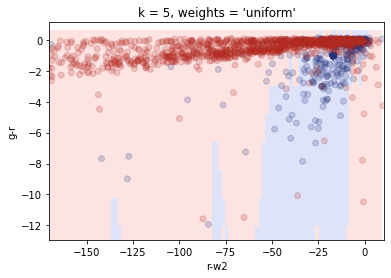

In [17]:
# g-r VS r-w2

features1 = [X['r']-X['w2'], X['g']-X['r']]
X1 = np.array(features1).transpose()
print(X1[:5, :], '\n length:\n', len(X1))
y1 = y
print(y1[:5])
'''
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3,random_state=42)

grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(neighbors.KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res = gs.fit(X1_train, y1_train)

print('best score: ', g_res.best_score_)
print('best params: ', g_res.best_params_)
'''
filter1 = neighbors.KNeighborsClassifier(metric='minkowski', n_neighbors=5, weights='uniform')
get_flux_filter(filter1, 5, 'uniform', X1, y1, qso_flux_r, qso_flux_w2, qso_flux_g, qso_flux_r)
plt.xlabel('r-w2')
plt.ylabel('g-r')
plt.show()

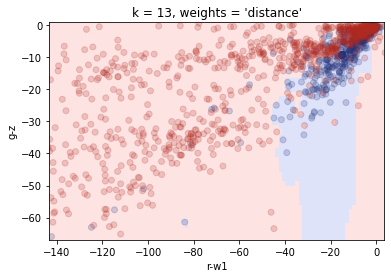

In [21]:
# g-z VS r-w1

features2 = [X['r']-X['w1'], X['g']-X['z']]
X2 = np.array(features2).transpose()
#print(X1[:5, :], '\n length:\n', len(X1))
y2 = y
#print(y1[:5])

'''
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3,random_state=42)

grid_params = { 'n_neighbors' : [5, 7, 9, 11, 13, 15, 20, 30],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs2 = GridSearchCV(neighbors.KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res2 = gs2.fit(X2_train, y2_train)

print('best score: ', g_res2.best_score_)
print('best params: ', g_res2.best_params_)
'''
filter2 = neighbors.KNeighborsClassifier(metric='manhattan', n_neighbors=13, weights='distance')
get_flux_filter(filter2, 13, 'distance', X2, y2, qso_flux_r, qso_flux_w1, qso_flux_g, qso_flux_z)
plt.xlabel('r-w1')
plt.ylabel('g-z')
plt.show()

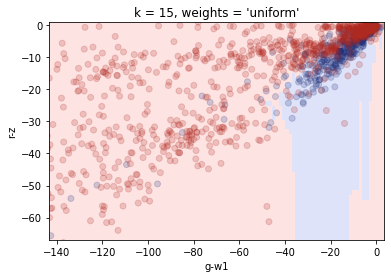

In [19]:
# r-z VS g-w1

features3 = [X['g']-X['w1'], X['r']-X['z']]
X3 = np.array(features3).transpose()
y3 = y
'''
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3,random_state=42)

grid_params = {'n_neighbors' : [5, 7, 9, 11, 13, 15, 20, 30],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs3 = GridSearchCV(neighbors.KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res3 = gs3.fit(X3_train, y3_train)

print('best score: ', g_res3.best_score_)
print('best params: ', g_res3.best_params_)
'''
filter3 = neighbors.KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='uniform')
get_flux_filter(filter3, 15, 'uniform', X3, y3, qso_flux_r, qso_flux_w1, qso_flux_g, qso_flux_z)
plt.xlabel('g-w1')
plt.ylabel('r-z')
plt.show()

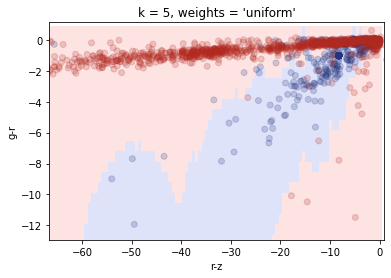

In [23]:
# g-r VS r-z
features4 = [X['r']-X['z'], X['g']-X['r']]
X4 = np.array(features4).transpose()
#print(X1[:5, :], '\n length:\n', len(X1))
y4 = y
#print(y1[:5])
'''
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3,random_state=42)

grid_params = {'n_neighbors' : [5, 7, 9, 11, 13, 15, 20],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs4 = GridSearchCV(neighbors.KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res4 = gs4.fit(X4_train, y4_train)

print('best score: ', g_res4.best_score_)
print('best params: ', g_res4.best_params_)
'''
filter4 = neighbors.KNeighborsClassifier(metric='minkowski', n_neighbors=5, weights='uniform')
get_flux_filter(filter4, 5, 'uniform', X4, y4, qso_flux_r, qso_flux_z, qso_flux_g, qso_flux_r)
plt.xlabel('r-z')
plt.ylabel('g-r')
plt.show()

In [71]:
# check the fraction of known qso after they go through these filters
qso_copy = data_qso.copy()
print(len(qso_copy))

# g-r VS r-w2
lab = filter1.predict(np.array([qso_copy['r']-qso_copy['w2'], qso_copy['g']-qso_copy['r']]).transpose())
qso_copy['label'] = lab
qso_copy = qso_copy[qso_copy['label'] == 1]

# g-z VS r-w1
lab = filter2.predict(np.array([qso_copy['r']-qso_copy['w1'], qso_copy['g']-qso_copy['z']]).transpose())
qso_copy['label'] = lab
qso_copy = qso_copy[qso_copy['label'] == 1]

# r-z VS g-w1
lab = filter3.predict(np.array([qso_copy['g']-qso_copy['w1'], qso_copy['r']-qso_copy['z']]).transpose())
qso_copy['label'] = lab
qso_copy = qso_copy[qso_copy['label'] == 1]

# g-r VS r-z, similr to r-w2
lab = filter4.predict(np.array([qso_copy['r']-qso_copy['z'], qso_copy['g']-qso_copy['r']]).transpose())
qso_copy['label'] = lab
qso_copy = qso_copy[qso_copy['label'] == 1]

print(len(qso_copy))

513
252


## SVM to select features with intercorrelations

### Linear svc 

### https://github.com/pierpaolo28/Companies-Data-Science-Challenges/blob/master/Microsoft%20Workshop%20-%20Deep%20Learning%20Data%20Analysis%20in%20Azure.ipynb

In [24]:
col_names = ['g', 'r', 'z', 'w1', 'w2']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            X[col] = X[col_names[i]] - X[col_names[j]]
print(X.columns)
print(type(X))

Index(['g', 'r', 'z', 'w1', 'w2', 'g-r', 'g-z', 'g-w1', 'g-w2', 'r-z', 'r-w1',
       'r-w2', 'z-w1', 'z-w2', 'w1-w2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>


/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


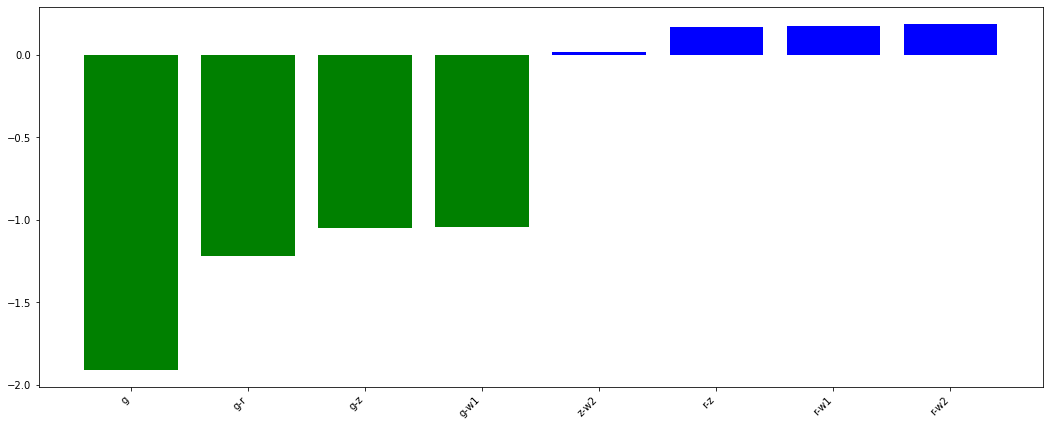

In [25]:
trainedsvm = svm.LinearSVC(max_iter = 2000).fit(X, y) # increase the iteration number here
coef = trainedsvm.coef_.ravel()

top_positive_coefficients = np.argsort(coef)[-4:]
top_negative_coefficients = np.argsort(coef)[:4]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(18, 7))
colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 4), coef[top_coefficients], color=colors)
feature_names = np.array(X.columns)
plt.xticks(np.arange(2 * 4), feature_names[top_coefficients], rotation=45, ha='right')
plt.show()

keep g-r, g-z, g-w1, r-z, r-w1, r-w2

In [26]:
keep_added_cols = ['g-r', 'g-z', 'g-w1', 'r-z', 'r-w1', 'r-w2']
print(type(X))
X = X[['g', 'r', 'z', 'w1', 'w2', 'g-r', 'g-z', 'g-w1', 'r-z', 'r-w1', 'r-w2']]

print('X: \n', X.head())
print(X.tail(5))
print('y: \n', y.head())
print(y.tail(5))

<class 'pandas.core.frame.DataFrame'>
X: 
           g         r          z         w1         w2       g-r        g-z  \
0 -0.027202  1.128900  15.478700  25.508100  31.962400 -1.156102 -15.505902   
1 -0.009716 -0.004347   0.447343   0.193634  -0.005911 -0.005369  -0.457059   
2 -0.009741 -0.002475   0.471304   1.737770   0.771748 -0.007266  -0.481045   
3  0.016594  1.172370  19.526800  26.206800  32.328100 -1.155776 -19.510206   
4  0.010978 -0.009939   0.837811   3.343330   1.152640  0.020917  -0.826833   

        g-w1        r-z       r-w1       r-w2  
0 -25.535302 -14.349800 -24.379200 -30.833500  
1  -0.203350  -0.451690  -0.197981   0.001564  
2  -1.747511  -0.473779  -1.740245  -0.774223  
3 -26.190206 -18.354430 -25.034430 -31.155730  
4  -3.332352  -0.847750  -3.353269  -1.162579  
                g              r           z           w1          w2  \
3423     0.001760       0.283210   10.638200    57.675300    43.33980   
3424     0.217841       0.231266    0.216917   3

## Training Model

In [27]:
X = X.to_numpy()
y = np.array(y, dtype=int)

In [20]:
estimators = []
f1_lst_n = []
train_score_n = []
test_score_n = []

for n_estimator in range(100, 400, 10):
    model = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    f1_sum = 0
    train_score_sum = 0
    test_score_sum = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_sum += f1
        train_score  = model.score(X_train,y_train) # mean accuracy
        train_score_sum += train_score
        test_score = model.score(X_test,y_test)
        test_score_sum += test_score
    f1_ave = f1_sum/10 
    train_score_ave = train_score_sum/10
    test_score_ave = test_score_sum/10
    estimators.append(n_estimator)
    f1_lst_n.append(f1_ave)
    train_score_n.append(train_score_ave)
    test_score_n.append(test_score_ave)

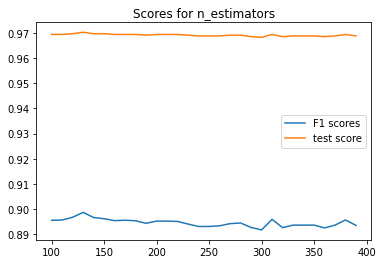

In [21]:
plt.plot(estimators, f1_lst_n, label='F1 scores')
#plt.plot(estimators, train_score_n, label='train scores')
plt.plot(estimators, test_score_n, label='test score')
plt.title('Scores for n_estimators')
plt.legend()
plt.show()

In [20]:
# get the top 10 n_estimators with the highest F1 scores
df_n = pd.DataFrame({'n_estimator': estimators, 'F1 score': f1_lst_n})
df_n = df_n.sort_values(by='F1 score', ascending=False)
print(df_n.head(10))

    n_estimator  F1 score
3           130  0.898678
2           120  0.896719
4           140  0.896619
5           150  0.896143
21          310  0.895903
28          380  0.895650
1           110  0.895631
7           170  0.895550
0           100  0.895511
6           160  0.895389


In [21]:
# plot (x: max_depth value, y: score)
depths = []
f1_lst_depth = []
train_score_depth = []
test_score_depth = []

for max_depth_value in range(2,50):
    model = RandomForestClassifier(n_estimators=130, max_depth=max_depth_value, random_state=42)
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    f1_sum = 0
    train_score_sum = 0
    test_score_sum = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_sum += f1
        train_score  = model.score(X_train,y_train)
        train_score_sum += train_score
        test_score = model.score(X_test,y_test)
        test_score_sum += test_score
    f1_ave = f1_sum/10 
    train_score_ave = train_score_sum/10
    test_score_ave = test_score_sum/10
    depths.append(max_depth_value)
    f1_lst_depth.append(f1_ave)
    train_score_depth.append(train_score_ave)
    test_score_depth.append(test_score_ave)

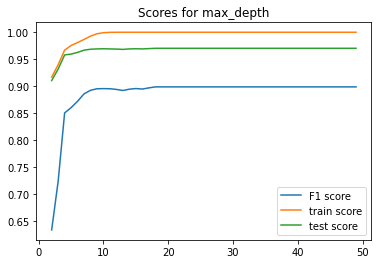

In [22]:
plt.plot(depths, f1_lst_depth, label='F1 score')
plt.plot(depths, train_score_depth, label='train score')
plt.plot(depths, test_score_depth, label='test score')
plt.title('Scores for max_depth')
plt.legend()
plt.show()

In [25]:
# get the top 10 max_depth with the highest F1 scores
df_depth = pd.DataFrame({'max_depth': depths, 'F1 score': f1_lst_depth})
df_depth = df_depth.sort_values(by='F1 score', ascending=False)
print(df_depth[df_depth['max_depth'] < 30])
# choose the values when the curve becomes stable in case of overfitting

    max_depth  F1 score
24         26  0.898678
27         29  0.898678
25         27  0.898678
26         28  0.898678
22         24  0.898678
21         23  0.898678
20         22  0.898678
19         21  0.898678
18         20  0.898678
17         19  0.898678
16         18  0.898678
23         25  0.898678
15         17  0.896798
13         15  0.895577
8          10  0.895457
9          11  0.895235
7           9  0.895214
14         16  0.894632
12         14  0.894395
10         12  0.893977
6           8  0.892329
11         13  0.891976
5           7  0.885788
4           6  0.871981
3           5  0.860168
2           4  0.850389
1           3  0.723475
0           2  0.633445


In [26]:
leaves = []
f1_lst_leaf = []
train_score_leaf = []
test_score_leaf = []

for min_leaf in range(2,30):
    model = RandomForestClassifier(n_estimators=130, max_depth=15, min_samples_leaf=min_leaf, random_state=42)
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    f1_sum = 0
    train_score_sum = 0
    test_score_sum = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_sum += f1
        train_score  = model.score(X_train,y_train)
        train_score_sum += train_score
        test_score = model.score(X_test,y_test)
        test_score_sum += test_score
    f1_ave = f1_sum/10 
    train_score_ave = train_score_sum/10
    test_score_ave = test_score_sum/10
    leaves.append(min_leaf)
    f1_lst_leaf.append(f1_ave)
    train_score_leaf.append(train_score_ave)
    test_score_leaf.append(test_score_ave)

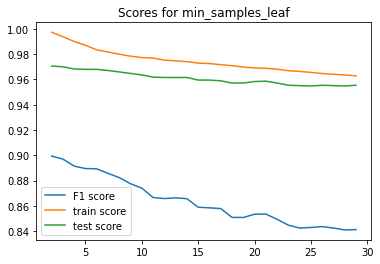

In [27]:
plt.plot(leaves, f1_lst_leaf, label='F1 score')
plt.plot(leaves, train_score_leaf, label='train score')
plt.plot(leaves, test_score_leaf, label='test score')
plt.title('Scores for min_samples_leaf')
plt.legend()
plt.show()

In [28]:
# get the top 10 min_samples_leaf with the highest F1 scores
df_leaf = pd.DataFrame({'min_samples_leaf': leaves, 'F1 score': f1_lst_leaf})
df_leaf = df_leaf.sort_values(by='F1 score', ascending=False)
print(df_leaf.head(10))

   min_samples_leaf  F1 score
0                 2  0.899417
1                 3  0.897000
2                 4  0.891448
3                 5  0.889557
4                 6  0.889299
5                 7  0.885745
6                 8  0.882382
7                 9  0.877527
8                10  0.874087
9                11  0.866647


In [29]:
splits = []
f1_lst_split = []
train_score_split = []
test_score_split = []

for min_split in range(2,35):
    model = RandomForestClassifier(n_estimators=130, max_depth=15, min_samples_leaf=2, min_samples_split=min_split, random_state=42)
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    f1_sum = 0
    train_score_sum = 0
    test_score_sum = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_sum += f1
        train_score  = model.score(X_train,y_train)
        train_score_sum += train_score
        test_score = model.score(X_test,y_test)
        test_score_sum += test_score
    f1_ave = f1_sum/10 
    train_score_ave = train_score_sum/10
    test_score_ave = test_score_sum/10
    splits.append(min_split)
    f1_lst_split.append(f1_ave)
    train_score_split.append(train_score_ave)
    test_score_split.append(test_score_ave)

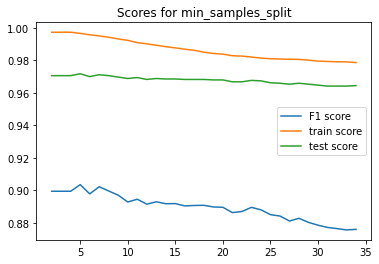

In [30]:
plt.plot(splits, f1_lst_split, label='F1 score')
plt.plot(splits, train_score_split, label='train score')
plt.plot(splits, test_score_split, label='test score')
plt.title('Scores for min_samples_split')
plt.legend()
plt.show()

In [43]:
# get the top 10 min_samples_split with the highest F1 scores
df_split = pd.DataFrame({'min_samples_split': splits, 'F1 score': f1_lst_split})
df_split = df_split.sort_values(by='F1 score', ascending=False)
print(df_split.head(10))
# 2, 3: suspecting overfitting

    min_samples_split  F1 score
3                   5  0.903480
5                   7  0.902198
6                   8  0.899569
0                   2  0.899417
1                   3  0.899417
2                   4  0.899417
4                   6  0.897799
7                   9  0.896981
9                  11  0.894512
11                 13  0.892923


In [28]:
# targeted training using GridSearch
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42, shuffle=True)

# check if there is any nan/inf in X
print(np.where(np.isnan(X_train)), np.where(np.isnan(X_test)), np.where(np.isnan(y_train)), np.where(np.isnan(y_test)))
print(np.where(np.isinf(X_train)), np.where(np.isinf(X_test)), np.where(np.isinf(y_train)), np.where(np.isinf(y_test)))


model_params = {'n_estimators': [130, 120, 140, 150, 310, 380, 110, 170, 100, 160],
                'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_split': [5, 7, 8, 4, 6, 9, 11, 13],
                'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                'max_depth': [26, 15, 10, 11, 9, 16, 14, 12, 8, 13]} # try to constrain the max_depth in [5, 15] https://stats.stackexchange.com/questions/111968/random-forest-how-to-handle-overfitting

# class_weight? like certain color ratios are more important than others?
# oob_score = True

clf = RandomForestClassifier(random_state=42)

rf = RandomizedSearchCV(estimator=clf, param_distributions=model_params, n_iter=100, cv=5, scoring='f1_macro', refit= 'f1_macro', verbose=1, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

print('best params:\n ')
print(rf.best_params_)

(array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64),) (array([], dtype=int64),)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
best params:
 
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 11}


In [29]:
print('best score: \n ')
print(rf.best_score_)

print('results:\n ')
print(pd.DataFrame(rf.cv_results_))

y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

#classification report -> overfitting Y/N
report_train = classification_report(y_train, y_train_pred)
report_test = classification_report(y_test, y_pred)
print("Classification report (training): \n", report_train)
print("Classification report (test): \n", report_test)

best score: 
 
0.9387010971286539
results:
 
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.337927      0.036522         0.072369        0.000830   
1        1.611965      0.034512         0.086835        0.001167   
2        0.587101      0.019491         0.032143        0.001074   
3        0.551760      0.031568         0.032071        0.000919   
4        1.611116      0.023206         0.089365        0.003203   
..            ...           ...              ...             ...   
95       0.470966      0.020594         0.023666        0.004372   
96       0.417026      0.018625         0.023031        0.001010   
97       0.397678      0.025072         0.018923        0.004407   
98       0.381281      0.018353         0.014094        0.000882   
99       0.342422      0.025797         0.014192        0.000233   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                 310                       9                     

now we have the best_params:

fixed -> {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}

{'n_estimators': 240, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12}

After adding SVM determined features:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 11}

(dec > 15.0 and dec < 40.0 and dered_mag_z > 16.0 and dered_mag_z < 23.0 and g_r> 1.8 and shape_r < 1.0 and (dered_mag_g > 24.0 or dered_flux_g < 0.0) and snr_g < 3.0 and snr_w1 > 3.0
                and mag_w1 != 'NaN' and mag_w2 != 'NaN' and mag_w1 != 'Infinity' and mag_w2 != 'Infinity' and mag_g != 'Infinity' and mag_r != 'Infinity')

(dered_mag_z > 16.0 and dered_mag_z < 23.0 and mag_w1 != 'NaN' and mag_w2 != 'NaN' and g_r> 1.8
               and mag_w1 != 'Infinity' and mag_w2 != 'Infinity' and mag_g != 'Infinity' and mag_r != 'Infinity' and shape_r < 1.0 and snr_g < 3.0
               and snr_w1 > 3.0 and dered_mag_g > 24.0 or dered_flux_g < 0.0 and dec > -5.0 and dec < 5.0)

# Prediction

In [37]:
%%time
# restrict ra and dec: 330<ra<360, 15<dec<40
aquery = """
        SELECT ra, dec, ls_id, flux_g, flux_r, flux_z, flux_w1, flux_w2, mag_g, mag_r, mag_z, mag_w1, mag_w2, g_r, snr_g, snr_r, snr_z, snr_w1, snr_w2
        FROM   ls_dr9.tractor_n
        WHERE  (dec > 15.0 and dec < 40.0 and ra > 210.0 and ra < 240.0 and dered_mag_z > 16.0 and dered_mag_z < 23.0 and g_r> 1.8 and shape_r < 1.0 and (dered_mag_g > 24.0 or dered_flux_g < 0.0) 
                and snr_g < 3.0 and snr_w1 > 3.0 and mag_w1 != 'NaN' and mag_w2 != 'NaN' and mag_w1 != 'Infinity' and mag_w2 != 'Infinity' and mag_g != 'Infinity' and mag_r != 'Infinity')
        """
### ls_dr8.tractor is the main catalog combining both north and south

### async mode returns jobid
jobid = qc.query(token, sql=aquery, fmt='csv', async_=True, timeout=3600, out='vos://LS_DR9N_part2.csv')
status = ''
while (status != 'COMPLETED' and status != 'ERROR'):
    status = qc.status(token,jobid)
    print(status)
    time.sleep(2)

print ('error message ', qc.error(token,jobid)) 

response=qc.results(token,jobid)
#df = qc.query(sql=aquery, fmt='pandas')
res = qc.query(sql=aquery, fmt='csv', out='vos://my_file_rf_flux.csv')

EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
EXECUTING
COMPLETED
error message  Error: list index out of range
CPU times: user 3.2 s, sys: 1.08 s, total: 4.28 s
Wall time: 5min 24s


keep_added_cols = ['g-r', 'g-z', 'g-w1', 'r-z', 'r-w1', 'r-w2']

add signal-to-noise ratio: snr_g   Signal-to-Noise ratio in g

In [38]:
data = sc.get('vos://my_file_rf_flux.csv') 
data = convert(data)
print(len(data))
print('Before modification: \n', data.head())
data = data.replace([np.inf, -np.inf], np.nan)
#data = data.dropna(axis='index').reset_index(drop=True)
columns = ['flux_g', 'flux_r', 'flux_w1', 'flux_w2', 'flux_z', 'mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'g_r', 'snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2']
data_replace = {}
for col in columns:
    data[col] = data[col].replace([np.nan], round(data[col].mean(), 6))
    data_replace[col] = round(data[col].mean(), 6)

snr = data[['snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2']]
mag = data[['mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'g_r']]
# data = data.drop(columns=['snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2', 'mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'g_r'], axis=1)

#snr = data[['snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2']]
#data = data.drop(columns=['snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2'], axis=1)

data['g-r'] = data['flux_g'] - data['flux_r']
data['g-z'] = data['flux_g'] - data['flux_z']
data['g-w1'] = data['flux_g'] - data['flux_w1']
data['r-z'] = data['flux_r'] - data['flux_z']
data['r-w1'] = data['flux_r'] - data['flux_w1']
data['r-w2'] = data['flux_r'] - data['flux_w2']


print(data.columns)
#print(len(data))
print('After modificaiton: \n', data.head())
print(len(data))
# print(type(data['mag_r'][0]))

570180
Before modification: 
            ra        dec             ls_id    flux_g    flux_r    flux_z  \
0  236.998649  39.989934  9907734910992898  0.038913  0.810338  3.265740   
1  236.931743  39.996128  9907734910930646  0.033196  0.332644  5.169561   
2  236.928356  39.997470  9907734910930611  0.105973  0.566404  2.459088   
3  236.929452  39.975666  9907734910930625  0.126606  0.700310  1.816079   
4  236.932113  39.994171  9907734910930649  0.002885  0.274474  2.320690   

     flux_w1   flux_w2      mag_g      mag_r      mag_z     mag_w1     mag_w2  \
0  14.752074  8.000422  26.024767  22.728334  21.215046  19.577868  20.242218   
1   4.726945  3.149611  26.197275  23.695051  20.716366  20.813549  21.254358   
2   1.687021  1.908822  24.937008  23.117184  21.523066  21.932200  21.798086   
3   6.071838  4.616308  24.743868  22.886774  21.852163  20.541700  20.839264   
4  10.185863  6.103012  28.849516  23.903748  21.585957  19.980005  20.536140   

        g_r     snr_g     

In [39]:
print('The replacement values: \n', data_replace)
print(np.where(np.isinf(data)))

The replacement values: 
 {'flux_g': -0.231063, 'flux_r': 0.541785, 'flux_w1': 16.620217, 'flux_w2': 114.690188, 'flux_z': 1.919387, 'mag_g': 26.132695, 'mag_r': 23.827642, 'mag_z': 22.026713, 'mag_w1': 20.408007, 'mag_w2': 20.930978, 'g_r': 2.542303, 'snr_g': 0.657045, 'snr_r': 4.538273, 'snr_z': 17.790373, 'snr_w1': 18.61086, 'snr_w2': 6.960281}
(array([], dtype=int64), array([], dtype=int64))


In [58]:
df = data.copy(deep=True)
print(df.head())

           ra        dec             ls_id    flux_g    flux_r    flux_z  \
0  236.998649  39.989934  9907734910992898  0.038913  0.810338  3.265740   
1  236.931743  39.996128  9907734910930646  0.033196  0.332644  5.169561   
2  236.928356  39.997470  9907734910930611  0.105973  0.566404  2.459088   
3  236.929452  39.975666  9907734910930625  0.126606  0.700310  1.816079   
4  236.932113  39.994171  9907734910930649  0.002885  0.274474  2.320690   

     flux_w1   flux_w2      mag_g      mag_r  ...     snr_r      snr_z  \
0  14.752074  8.000422  26.024767  22.728334  ...  8.773003  34.296894   
1   4.726945  3.149611  26.197275  23.695051  ...  3.632156  50.640087   
2   1.687021  1.908822  24.937008  23.117184  ...  6.115084  25.077795   
3   6.071838  4.616308  24.743868  22.886774  ...  8.162531  13.142480   
4  10.185863  6.103012  28.849516  23.903748  ...  2.891031  21.510197   

      snr_w1    snr_w2       g-r       g-z       g-w1       r-z       r-w1  \
0  27.211966  8.6437

## apply filters to unknown data

signal-to-noise ratio filter

In [59]:
# S/N(g) < 3.
df = df[df['snr_g'] < 3.0]

# S/N(r) < 5.
df = df[df['snr_r'] < 5.0]

#S/N(w1) > 5
df = df[df['snr_w1'] > 5.0]

print(len(df))
df = df.drop(columns=['ra', 'dec', 'mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2', 'g_r'], axis=1)
print(df.head())

330117
              ls_id    flux_g    flux_r    flux_z    flux_w1   flux_w2  \
1  9907734910930646  0.033196  0.332644  5.169561   4.726945  3.149611   
4  9907734910930649  0.002885  0.274474  2.320690  10.185863  6.103012   
5  9907734910929875 -0.027191  0.341905  1.766481   5.084484  5.472089   
6  9907734910930320  0.031633  0.309972  1.868744   7.606565  6.045792   
8  9907734910930064  0.017675  0.176046  0.804787   6.797914  7.535524   

        g-r       g-z       g-w1       r-z      r-w1      r-w2  
1 -0.299448 -5.136365  -4.693749 -4.836917 -4.394301 -2.816967  
4 -0.271589 -2.317805 -10.182978 -2.046216 -9.911389 -5.828538  
5 -0.369096 -1.793672  -5.111675 -1.424576 -4.742579 -5.130184  
6 -0.278339 -1.837111  -7.574932 -1.558772 -7.296593 -5.735820  
8 -0.158371 -0.787112  -6.780239 -0.628741 -6.621868 -7.359478  


In [60]:
# remove dtype=float
# X_data = pd.DataFrame({'ls_id': ls_id, 'mag_g': mag_g, 'mag_r': mag_r, 'mag_z': mag_z, 'mag_w1': mag_w1, 'mag_w2': mag_w2})
#X_new = X_data[['mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2']]
if 'label' in df.columns:
    df = df.drop(columns=['label'])
X_new = df.drop(columns=['ls_id'])
print(X_new.head(), '\n', len(X_new))
X_new = X_new.to_numpy()
#print(X_new[5, ])
print(np.where(np.isinf(X_new)), np.where(np.isnan(X_new)))

     flux_g    flux_r    flux_z    flux_w1   flux_w2       g-r       g-z  \
1  0.033196  0.332644  5.169561   4.726945  3.149611 -0.299448 -5.136365   
4  0.002885  0.274474  2.320690  10.185863  6.103012 -0.271589 -2.317805   
5 -0.027191  0.341905  1.766481   5.084484  5.472089 -0.369096 -1.793672   
6  0.031633  0.309972  1.868744   7.606565  6.045792 -0.278339 -1.837111   
8  0.017675  0.176046  0.804787   6.797914  7.535524 -0.158371 -0.787112   

        g-w1       r-z      r-w1      r-w2  
1  -4.693749 -4.836917 -4.394301 -2.816967  
4 -10.182978 -2.046216 -9.911389 -5.828538  
5  -5.111675 -1.424576 -4.742579 -5.130184  
6  -7.574932 -1.558772 -7.296593 -5.735820  
8  -6.780239 -0.628741 -6.621868 -7.359478   
 330117
(array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))


In [61]:
# Check if there is still nan/inf
print(np.where(np.isnan(X_new)), np.where(np.isinf(X_new)))

(array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))


In [62]:
clf_flux = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features='auto', max_depth=11)

In [63]:
clf_flux.fit(X_train, y_train) # X, y from training sample
# predict the unknown data retrieved from ls
y_new = clf_flux.predict(X_new) 

results = df.loc[y_new == 1, 'ls_id']

print(len(results))
print(results.head())

# get the ls_id corresponding to the predicted results
df['label'] = y_new

# predict a 2nd round
X_second = df[df['label'] == 1]
#print(X_second.head())

y_second = clf_flux.predict(X_second.drop(columns=['label', 'ls_id']).to_numpy())
df = X_second

results = df.loc[y_second == 1, 'ls_id']
print(df.head(), len(df))
print(results.head())

print(len(results))

134650
1     9907734910930646
4     9907734910930649
9     9907734910929927
10    9907734910929840
15    9907734910929409
Name: ls_id, dtype: int64
               ls_id    flux_g    flux_r    flux_z    flux_w1   flux_w2  \
1   9907734910930646  0.033196  0.332644  5.169561   4.726945  3.149611   
4   9907734910930649  0.002885  0.274474  2.320690  10.185863  6.103012   
9   9907734910929927  0.004552  0.093586  0.935963   4.246901  2.509134   
10  9907734910929840  0.051178  0.285539  0.793587   3.942533  0.388740   
15  9907734910929409  0.005286  0.152944  0.805419   3.199718  0.668292   

         g-r       g-z       g-w1       r-z      r-w1      r-w2  label  
1  -0.299448 -5.136365  -4.693749 -4.836917 -4.394301 -2.816967      1  
4  -0.271589 -2.317805 -10.182978 -2.046216 -9.911389 -5.828538      1  
9  -0.089034 -0.931411  -4.242349 -0.842377 -4.153315 -2.415548      1  
10 -0.234361 -0.742409  -3.891355 -0.508048 -3.656994 -0.103201      1  
15 -0.147658 -0.800133  -3.194432 -0

## KNN flux filters

g-r VS r-w2

g-z VS r-w1

r-z VS g-w1

g-r VS r-z

In [64]:
# g-r VS r-w2
labels = filter1.predict(np.array([df['r-w2'], df['g-r']]).transpose())
df['label'] = labels
df = df[df['label'] == 1]
print(len(df))

# g-z VS r-w1
labels = filter2.predict(np.array([df['r-w1'], df['g-z']]).transpose())
df['label'] = labels
df = df[df['label'] == 1]
print(len(df))

# r-z VS g-w1
labels = filter3.predict(np.array([df['flux_g']-df['flux_w1'], df['r-z']]).transpose())
df['label'] = labels
df = df[df['label'] == 1]
labels = df['label']
print(len(df))

# g-r VS r-z, similr to r-w2
labels = filter4.predict(np.array([df['r-z'], df['g-r']]).transpose())
df['label'] = labels
df = df[df['label'] == 1]
print(len(df))

99012


/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


11787
6336
2151


color filters

roughly g-r:>2, g-z:>4, r-w1: 1.8-3, r-w2:1.7-3.2, z-w1, z-w2: 0-1

### add magnitude back to apply the filters

In [37]:
df = data[data['ls_id'].isin(results)]
#print(type(results))
labels = X_second['label'].tolist()
df['label'] = labels
print(df.head())
print(len(df))

/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [33]:
df = df[(df['mag_g'] - df['mag_z']) > 4.]
print(len(df))

df = df[(df['mag_r'] - df['mag_w1']) > 1.8]
df = df[(df['mag_r'] - df['mag_w1']) < 3.0]
print(len(df))

df = df[(df['mag_r'] - df['mag_w2']) > 1.7]
df = df[(df['mag_r'] - df['mag_w1']) < 3.2]
print(len(df))

df = df[(df['mag_z'] - df['mag_w1']) > 0.]
df = df[(df['mag_z'] - df['mag_w1']) < 1.]
print(len(df))

df = df[(df['mag_z'] - df['mag_w2']) > 0.]
df = df[(df['mag_z'] - df['mag_w2']) < 1.]
print(len(df))

23549
5592
3894
1045
657


In [65]:
labels = df['label']
df = data[data['ls_id'].isin(df['ls_id'])]
df['label'] = labels
print(df.head(), '\n', len(df))

             ra        dec             ls_id    flux_g    flux_r    flux_z  \
1    236.931743  39.996128  9907734910930646  0.033196  0.332644  5.169561   
211  236.272035  39.937320  9907734910799554  0.021132  0.303773  2.681970   
234  236.210692  39.951349  9907734910798747  0.032903  0.359839  3.308487   
351  236.085604  39.771788  9907734838185818  0.005412  0.300857  4.882315   
474  235.885855  39.929120  9907734910732995  0.035322  0.360024  3.532602   

      flux_w1   flux_w2      mag_g      mag_r  ...      snr_z     snr_w1  \
1    4.726945  3.149611  26.197275  23.695051  ...  50.640087  11.301957   
211  2.517809  0.556828  26.687664  23.793627  ...  36.918060   6.043969   
234  2.627269  2.285292  26.206923  23.609730  ...  45.598312   6.406215   
351  5.100372  3.479911  28.166520  23.804100  ...  57.642610  12.058116   
474  3.052542  2.241541  26.129885  23.609170  ...  38.603207   7.443428   

       snr_w2       g-r       g-z      g-w1       r-z      r-w1      r-w2 

/data0/sw/antares-kernel-0.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
# The typical W1 − W2 cut used for quasar selection is W1 − W2 > 0.5  Exploring Reionizaiton Quasars IV
df = df[(df['mag_w1'] - df['mag_w2']) > 0.5]
print(len(df))

# reject z > 23.3
df = df[df['mag_z'] <= 23.3]
print(len(df))

44
44


### extracting and re-formatting results

In [67]:
results = df.loc[df['label'] == 1, 'ls_id']
print(results.head())
print(type(results))
print(data.head())  
output = data[data['ls_id'].isin(results.values)]
print(output.head())
print(type(output))
print(len(output))

8022     9907734910010922
18185    9907734617656608
71680    9907734020229201
83273    9907734762491535
85925    9907734616081893
Name: ls_id, dtype: int64
<class 'pandas.core.series.Series'>
           ra        dec             ls_id    flux_g    flux_r    flux_z  \
0  236.998649  39.989934  9907734910992898  0.038913  0.810338  3.265740   
1  236.931743  39.996128  9907734910930646  0.033196  0.332644  5.169561   
2  236.928356  39.997470  9907734910930611  0.105973  0.566404  2.459088   
3  236.929452  39.975666  9907734910930625  0.126606  0.700310  1.816079   
4  236.932113  39.994171  9907734910930649  0.002885  0.274474  2.320690   

     flux_w1   flux_w2      mag_g      mag_r  ...     snr_r      snr_z  \
0  14.752074  8.000422  26.024767  22.728334  ...  8.773003  34.296894   
1   4.726945  3.149611  26.197275  23.695051  ...  3.632156  50.640087   
2   1.687021  1.908822  24.937008  23.117184  ...  6.115084  25.077795   
3   6.071838  4.616308  24.743868  22.886774  ...  8.16

### output file

In [68]:
# now put NaN back
print(data_replace.keys())
print(output.columns)
for col in data_replace.keys():
    if col in output.columns:
        output.loc[output[col] == data_replace[col], col] = np.nan
print(output.head())

dict_keys(['flux_g', 'flux_r', 'flux_w1', 'flux_w2', 'flux_z', 'mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'g_r', 'snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2'])
Index(['ra', 'dec', 'ls_id', 'flux_g', 'flux_r', 'flux_z', 'flux_w1',
       'flux_w2', 'mag_g', 'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'g_r',
       'snr_g', 'snr_r', 'snr_z', 'snr_w1', 'snr_w2', 'g-r', 'g-z', 'g-w1',
       'r-z', 'r-w1', 'r-w2'],
      dtype='object')
               ra        dec             ls_id    flux_g    flux_r     flux_z  \
8022   232.200085  39.914690  9907734910010922  0.029165  0.250486   2.900055   
18185  230.044845  38.911884  9907734617656608 -0.349438  0.054333   3.781512   
71680  224.544242  37.025417  9907734020229201  0.038780  0.344733   3.247623   
83273  221.976920  39.434004  9907734762491535 -0.018301  0.311644   3.877036   
85925  222.152817  39.103135  9907734616081893 -0.057693 -0.187543  10.991872   

        flux_w1    flux_w2      mag_g      mag_r  ...     snr_r      snr_z  \

/home/jail/dlusers/jlmaurora/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


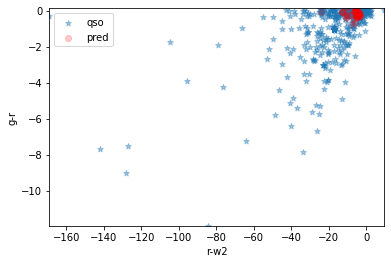

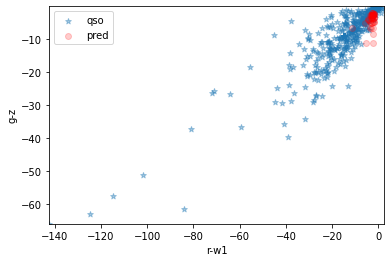

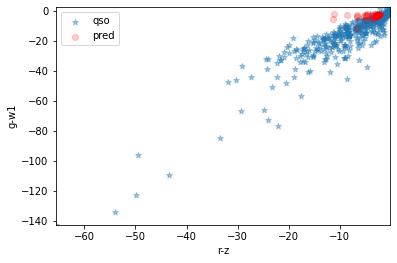

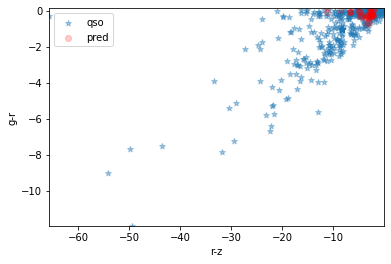

In [72]:
# g-r VS r-w2
flux_color(qso_flux_r, qso_flux_w2, qso_flux_g, qso_flux_r, 'r-w2', 'g-r')
plt.scatter(output['flux_r'] - output['flux_w2'], output['flux_g'] - output['flux_r'], marker='o', alpha=0.2, label='pred', color='r')
plt.legend()
plt.show()

# g-z VS r-w1
flux_color(qso_flux_r, qso_flux_w1, qso_flux_g, qso_flux_z, 'r-w1', 'g-z')
plt.scatter(output['flux_r'] - output['flux_w1'], output['flux_g'] - output['flux_z'], marker='o', alpha=0.2, label='pred', color='r')
plt.legend()
plt.show()

# r-z VS g-w1
flux_color(qso_flux_r, qso_flux_z, qso_flux_g, qso_flux_w1, 'r-z', 'g-w1')
plt.scatter(output['flux_r'] - output['flux_z'], output['flux_g'] - output['flux_w1'], marker='o', alpha=0.2, label='pred', color='r')
plt.legend()
plt.show()

# g-r VS r-z
flux_color(qso_flux_r, qso_flux_z, qso_flux_g, qso_flux_r, 'r-z', 'g-r')
plt.scatter(output['flux_r'] - output['flux_z'], output['flux_g'] - output['flux_r'], marker='o', alpha=0.2, label='pred', color='r')
plt.legend()
plt.show()

In [69]:
outfile = 'rf_flux_results03.csv'
output.to_csv(outfile, index=False)
output.to_csv(r'rf_flux_results03.csv')

# The flux ratio

In [30]:
# data from the new, unknown classification data set (ls_9)
ls_id = data['ls_id']
flux_g = data['flux_g']
flux_r = data['flux_r']
flux_z = data['flux_z']
flux_w1 = data['flux_w1']
flux_w2 = data['flux_w2']

gz = flux_g/flux_z
gw1 = flux_g/flux_w1
gw2 = flux_g/flux_w2
rz = flux_r/flux_z
rw1 = flux_r/flux_w1
rw2 = flux_r/flux_w2

print(gz.head())

0    0.018094
1    0.034895
2   -0.002553
3    0.053671
4    0.009914
dtype: float64


In [31]:
key = input('Enter flux or ratio: ')

if key == 'flux':
    X_data = pd.DataFrame({'ls_id': ls_id, 'flux_g': flux_g, 'flux_r': flux_r, 'flux_z': flux_z, 'flux_w1': flux_w1, 'flux_w2': flux_w2})
    X_new = X_data['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2']
    X_new = X_new.to_numpy()
if key == 'ratio':
    X_data = pd.DataFrame({'ls_id': ls_id, 'g/z': gz, 'g/w1': gw1, 'g/w2': gw2, 'r/z':rz, 'r/w1': rw1, 'r/w2': rw2})
    X_data = X_data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    X_new = X_data[['g/z', 'g/w1', 'g/w2', 'r/z', 'r/w1', 'r/w2']]
    print(X_new.head())
    X_new = X_new.to_numpy()
print(X_data.head())

Enter flux or ratio:  ratio


        g/z      g/w1      g/w2       r/z      r/w1      r/w2
0  0.018094  0.003009  0.004159  0.109694  0.018244  0.025215
1  0.034895  0.031328  0.226913  0.121176  0.108791  0.787980
2 -0.002553 -0.003687 -0.005502  0.138022  0.199340  0.297480
3  0.053671  0.015957  0.016512  0.379883  0.112943  0.116873
4  0.009914  0.005206  0.586951  0.108904  0.057183  6.447289
              ls_id       g/z      g/w1      g/w2       r/z      r/w1  \
0  8797230031570227  0.018094  0.003009  0.004159  0.109694  0.018244   
1  8797230031504347  0.034895  0.031328  0.226913  0.121176  0.108791   
2  8797230031570131 -0.002553 -0.003687 -0.005502  0.138022  0.199340   
3  8797230031504374  0.053671  0.015957  0.016512  0.379883  0.112943   
4  8797230031570284  0.009914  0.005206  0.586951  0.108904  0.057183   

       r/w2  
0  0.025215  
1  0.787980  
2  0.297480  
3  0.116873  
4  6.447289  


In [32]:
print(np.where(np.isnan(X_new)), np.where(np.isinf(X_new)))

(array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))


Best params:



In [10]:
clf_flux_ratio = RandomForestClassifier(n_estimators=120, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=15)

In [11]:
clf_flux_ratio.fit(X_train, y_train) # X, y from training sample
y_new = clf_flux_ratio.predict(X_new) 
print(y_new)

NameError: name 'X_train' is not defined

In [ ]:
X_data['label'] = y_new
results = X_data.loc[X_data['label'] == 1, 'ls_id']
print(results)

In [ ]:
outfile = 'rf_flux_ratio_results.csv'
results.to_csv(outfile, index=False)
# results.to_csv(r'D:\ahhhhh\research\classification results\rf_flux_ratio_results.csv')

In [3]:
# check the tables to get which ones to SELECT
print(qc.schema('ls_dr9.tractor_n'))
print(qc.schema('ls_dr9.tractor_n.shape_r'))


Schema: ls_dr9
 Table: tractor_n

     Column Name   Description
     -----------   -----------
           ls_id   Unique LS object ID
             dec   Declination at equinox J2000
              ra   Right ascension at equinox J2000
            elat   Ecliptic Latitude
            elon   Ecliptic Longitude
            glat   Galactic Latitude
            glon   Galactic Longitude
         mjd_max   Maximum Modified Julian Date of observations used to const
                   ruct the model of this object
         mjd_min   Minimum Modified Julian Date of observations used to const
                   ruct the model of this object
          ref_id   Reference catalog identifier for this star; Tyc1*1,000,000
                   +Tyc2*10+Tyc3 for Tycho2; sourceid for Gaia DR2 and SGA
         brickid   Brick ID [1,662174]
      blob_nea_g   Blob-masked noise equivalent area in g.
      blob_nea_r   Blob-masked noise equivalent area in r.
      blob_nea_z   Blob-masked noise equivalent ar

In [15]:
%%time

query = """
        SELECT brickid, objid, wise_coadd_id, ring256
        FROM ls_dr9.tractor_n
        LIMIT 20
        """

### async mode returns jobid
jobid_ls = qc.query(token, sql=query, fmt='csv', async_=True, timeout=3600, out='vos://ls_id.csv')
status = ''
while (status != 'COMPLETED' and status != 'ERROR'):
    status = qc.status(token, jobid_ls)
    print(status)
    time.sleep(2)

print ('error message ', qc.error(token, jobid_ls)) 

response_ls = qc.results(token,jobid_ls)
#df = qc.query(sql=aquery, fmt='pandas')
res_ls = qc.query(sql=query, fmt='csv', out='vos://my_file_ls_id.csv')

data_ls = sc.get('vos://my_file_ls_id.csv') 
data_ls = convert(data_ls)
print(data_ls.head())

EXECUTING
COMPLETED
error message  Error: list index out of range
   brickid  objid wise_coadd_id  ring256
0   559981    440      2871p439   121323
1   559981    421      2871p439   121323
2   559981    432      2871p439   121323
3   559981    460      2871p439   121323
4   559981    447      2871p439   121323
CPU times: user 172 ms, sys: 7.28 ms, total: 179 ms
Wall time: 7.5 s


In [8]:
print(qc.schema('des_dr1.main'))


Schema: des_dr1
 Table: main

     Column Name   Description
     -----------   -----------
 coadd_object_id   Unique identifier for the coadded objects
         hpix_32   Healpix ID for nside=32, nested schema
         hpix_64   Healpix ID for nside=64, nested schema
       hpix_1024   Healpix ID for nside=1024, nested schema
       hpix_4096   Healpix ID for nside=4096, nested schema
      hpix_16384   Healpix ID for nside=16384, nested schema
              ra   Right ascension, with quantized precision for indexing (AL
                   PHAWIN_J2000 has full precision but not indexed)
             dec   Declination, with quantized precision for indexing (DELTAW
                   IN_J2000 has full precision but not indexed)
  alphawin_j2000   Right ascension for the object, J2000 in ICRS system (full
                   precision but not indexed)
  deltawin_j2000   Declination for the object, J2000 in ICRS (full precision 
                   but not indexed)
      galactic_l   Gala

In [14]:
%%time

query2 = """
        SELECT coadd_object_id, ring256
        FROM des_dr1.main
        LIMIT 20
        """

### async mode returns jobid
jobid_des = qc.query(token, sql=query2, fmt='csv', async_=True, timeout=3600, out='vos://DES_DR1_pt1.csv')
status = ''
while (status != 'COMPLETED' and status != 'ERROR'):
    status = qc.status(token, jobid_des)
    print(status)
    time.sleep(2)

print ('error message ', qc.error(token, jobid_des)) 

response_des = qc.results(token,jobid_des)
#df = qc.query(sql=aquery, fmt='pandas')
res_des = qc.query(sql=query2, fmt='csv', out='vos://my_file_des_id.csv')

data_des = sc.get('vos://my_file_des_id.csv') 
data_des = convert(data_des)
print(len(data_des))
print(data_des.head())

EXECUTING
EXECUTING
COMPLETED
error message  Error: list index out of range
20
   coadd_object_id  ring256
0        207156094   645536
1        207156030   645536
2        207156119   645536
3        207156222   645536
4        207156176   645536
CPU times: user 195 ms, sys: 8.02 ms, total: 203 ms
Wall time: 10.5 s


In [6]:
print(qc.schema('ls_dr8.tractor_n.shapedev_r'))


	     column_name : shapedev_r
	      table_name : ls_dr8.tractor_n
	        datatype : adql:REAL
	       arraysize : 1
	           utype : 
	            unit : arcsec
	             ucd : 
	         indexed : False



In [4]:
# just some comparison between the two versions
print(qc.schema('ls_dr8.tractor_n'))


Schema: ls_dr8
 Table: tractor_n

     Column Name   Description
     -----------   -----------
      brightblob   bitwise mask indicating that an object is near a bright fo
                   reground source, as cataloged on the <a href='http://legac
                   ysurvey.org/dr8/bitmasks'>DR8 bitmasks page</a>
        maskbits   bitwise mask indicating that an object touches a pixel in 
                   the coadd/*/*/*maskbits* maps, as cataloged on the <a href
                   ='http://legacysurvey.org/dr8/bitmasks'>DR8 bitmasks page<
                   /a>
             dec   Declination at equinox J2000
            elat   Ecliptic Latitude
            elon   Ecliptic Longitude
            glat   Galactic Latitude
            glon   Galactic Longitude
         mjd_max   Maximum Modified Julian Date of observations used to const
                   ruct the model of this object
         mjd_min   Minimum Modified Julian Date of observations used to const
                   r